In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from utils.utils import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import shap
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from utils.utils import *
import time
sales = pd.read_excel('cryptopunk_sales.xlsx')
metadata = pd.read_csv('cryptopunk_metadata.csv')
cryptopunks_skin = pd.read_csv('cryptopunks_skin.csv')
floor = pd.read_csv('punk floor.csv')

metadata = metadata.merge(cryptopunks_skin, left_on = 'ID', right_on = 'id')
to_dummies = ['Gender','skin']#,  'skinColor']# 'year_month', 

for column in to_dummies:
    dummies = pd.get_dummies(metadata[column])
    # Generate dummy variables, prefix the original column name to each dummy column
    dummies.columns = [f"{column}_{col}" for col in dummies.columns]
    # Now, `dummies` has column names with both the original column name and the value.
    metadata = pd.concat([metadata, dummies], axis=1)

to_dummies = ['Gender','skin']#,  'skinColor']# 'year_month', 

for column in to_dummies:
    metadata.drop(column, axis=1, inplace=True)

eth = get_ethereum_price_history()
sales['block_date']= pd.to_datetime(sales.block_date)
sales = pd.merge(sales, eth, left_on  = 'block_date', right_on = 'Date')

sales = sales[sales.amount_original>3]
excluded_sales = exclude_top_and_bottom_x_percent(sales.amount_original, 2)
sales = sales[sales.amount_original.isin(excluded_sales)]
sales = sales[sales.block_date> '2021-02-01']

sales = sales[['block_date', 'block_month', 'token_id', 'amount_usd', 'amount_original', 'Ethereum_Price']]

unique_attributes = set()
attribute_columns = [col for col in metadata.columns if 'Attribute' in col]
for col in attribute_columns:
    unique_attributes.update(metadata[col].dropna().unique())

# Creating dummy variables
for attribute in unique_attributes:
    metadata[attribute] = metadata[attribute_columns].apply(lambda x: attribute in x.values, axis=1).astype(int)

metadata = metadata[pd.Series(metadata.columns)[~pd.Series(metadata.columns).isin(attribute_columns)]]
sales = pd.merge(sales, metadata, left_on = 'token_id', right_on = 'ID')


floor['day'] = pd.to_datetime(floor.day)
sales = sales.merge(floor, left_on = 'block_date', right_on = 'day')

earliest_year = sales['block_date'].dt.year.min()
sales['relative_month_number'] = ((sales['block_date'].dt.year - earliest_year) * 12 + sales['block_date'].dt.month)
sales['relative_month_number'] = sales['relative_month_number'] - 12

print('Dataset shape:', sales.shape)
sales.head()

Dataset shape: (16362, 114)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,block_date,block_month,token_id,amount_usd,amount_original,Ethereum_Price,ID,Category,id,url,...,Crazy Hair,Mole,Mustache,Mohawk Thin,Small Shades,Unnamed: 0,day,CP Price,BAYC Price,relative_month_number
0,2022-08-31,2022-08-01,9851,108431.9455,67.45,1525.400116,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,1,0,0,0,2068,2022-08-31,76.2250,77.3125,8
1,2022-11-27,2022-11-01,9851,83835.9581,68.99,1205.657960,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,1,0,0,0,2156,2022-11-27,66.8650,63.6875,11
2,2022-11-27,2022-11-01,8542,80671.0482,66.19,1205.657960,8542,2,8542,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,0,0,2156,2022-11-27,66.8650,63.6875,11
3,2022-11-27,2022-11-01,8740,95788.4037,78.87,1205.657960,8740,3,8740,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,0,0,1,0,2156,2022-11-27,66.8650,63.6875,11
4,2022-09-28,2022-09-01,9851,87519.0855,66.99,1331.150177,9851,3,9851,https://www.larvalabs.com/cryptopunks/cryptopu...,...,0,1,0,0,0,2096,2022-09-28,68.1175,76.7525,9


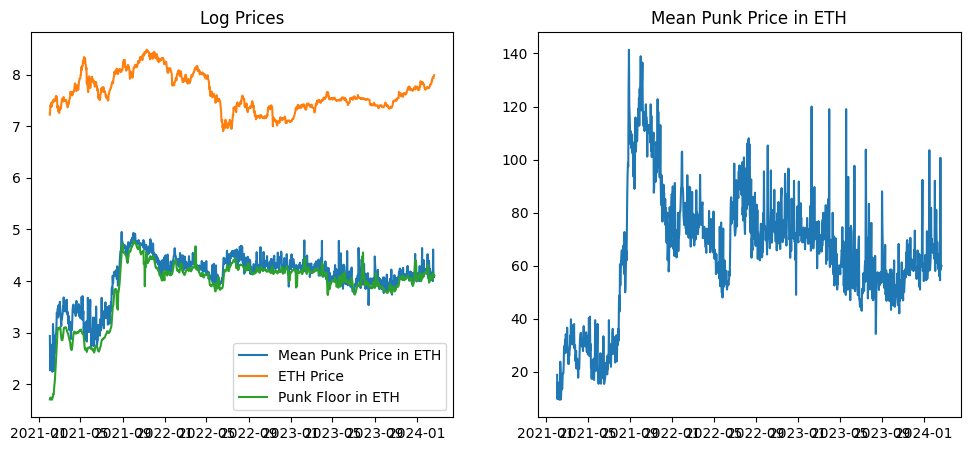

In [3]:
plot_eth_and_punk_prices(sales)

In [4]:

relevant_columns_model = ['amount_original', 'CP Price',
       'Category', 'Front Beard Dark', 'VR', 'Clown Eyes Green',
       'Buck Teeth', 'Wild Hair', 'Silver Chain', 'Cigarette',
       'Purple Eye Shadow', 'Pigtails', 'Handlebars', 'Normal Beard',
       'Blonde Bob', 'Muttonchops', 'Smile', 'Shaved Head', 'Mustache',
       'Mohawk Dark', 'Straight Hair', 'Choker', 'Regular Shades',
       'Peak Spike', 'Tassle Hat', 'Dark Hair', 'Knitted Cap', 'Bandana',
       'Pink With Hat', 'Gold Chain', 'Mohawk', 'Welding Goggles',
       'Cap Forward', 'Tiara', 'Purple Lipstick', 'Small Shades',
       'Stringy Hair', 'Do-rag', 'Wild White Hair', 'Frown', 'Red Mohawk',
       'Half Shaved', 'Clown Hair Green', 'Vampire Hair', 'Beanie',
       'Clown Nose', 'Messy Hair', 'Blonde Short', 'Mole', 'Purple Hair',
       'Chinstrap', 'Orange Side', 'Hot Lipstick', 'Horned Rim Glasses', 'Cap',
       'Green Eye Shadow', 'Nerd Glasses', 'Rosy Cheeks', 'Pilot Helmet',
       'Straight Hair Dark', 'Medical Mask', 'Frumpy Hair', 'Wild Blonde',
       'Hoodie', 'Earring', 'Big Shades', 'Spots', 'Headband', 'Goat',
       'Big Beard', 'Classic Shades', 'Clown Eyes Blue', 'Blue Eye Shadow',
       'Cowboy Hat', 'Luxurious Beard', 'Crazy Hair', 'Normal Beard Black',
       'Fedora', 'Straight Hair Blonde', 'Vape', 'Mohawk Thin', 'Front Beard',
       '3D Glasses', 'Police Cap', 'Top Hat', 'Shadow Beard', 'Eye Mask',
       'Black Lipstick', 'Eye Patch', 'Pipe', 'relative_month_number',  
       'skin_Arab', 'skin_Black', 'skin_Latino', 'skin_white', 'Gender_Alien',
        'Gender_Ape','Gender_Female', 'Gender_Male', 'Gender_Zombie', 'Ethereum_Price']
sales = sales[relevant_columns_model]



sales = sales.dropna(subset = 'amount_original')
sales = sales
sales.reset_index(inplace=True, drop=True)

X = sales[pd.Series(sales.columns)[pd.Series(sales.columns)!='amount_original'].values]
#X = X.drop(['skin_Ape', 'skin_Zombie', 'skin_Alien'], axis=1)
y = sales['amount_original']  # Your target vector

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 96
[LightGBM] [Info] Using GPU Device: GeForce GTX 960, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.10 MB) transferred to GPU in 0.001451 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 55.843794
Mean Average Absolute error in ETH: 5.835322103515586
Mean Average Absolute Percentage error: 12.97184288535051


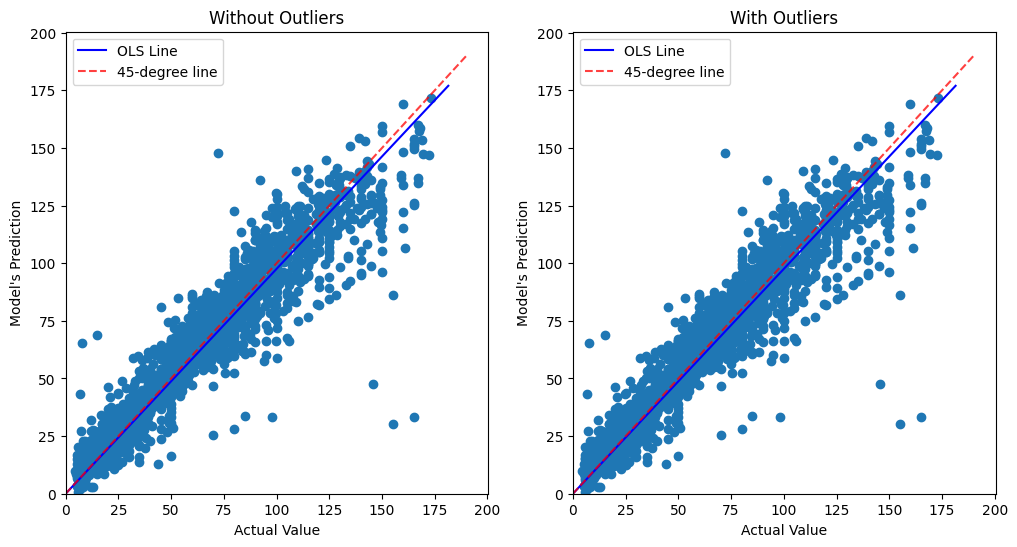

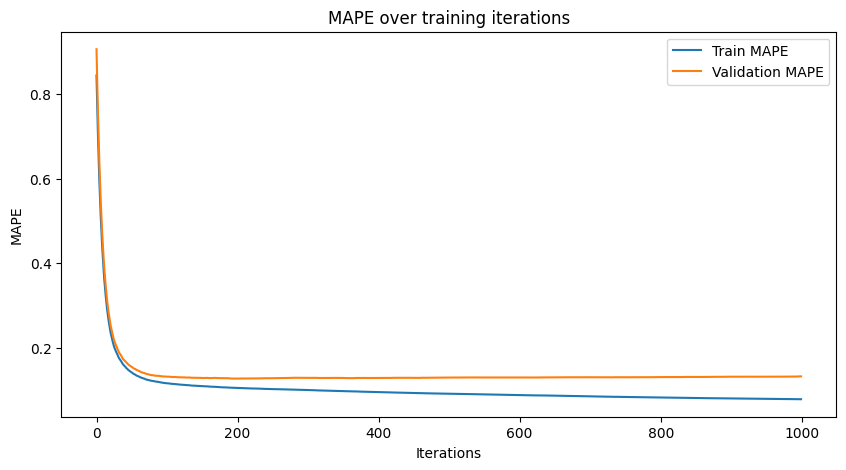

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test, reference=dtrain)
 
params = {
    'objective': 'regression',
    'metric': 'mape',
    'device': 'gpu',
    }

evals={}

bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], num_boost_round=1000,
                callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )

X_test_eval = X_test.copy()
X_test_eval['y_pred_gb_lgb'] = bst.predict(X_test_eval[pd.Series(X_test_eval.columns)[~pd.Series(X_test_eval.columns).isin(['numberId', 'year_month'])].values], num_iteration=bst.best_iteration)
X_test_eval['y_test'] = y_test
X_test_eval['error'] = X_test_eval['y_test'] - X_test_eval['y_pred_gb_lgb']
X_test_eval['perc_error']  = ((1- (X_test_eval['y_test']/X_test_eval['y_pred_gb_lgb']))*100)
X_test_eval['perc_error_abs'] = X_test_eval.perc_error.abs()

print('Mean Average Absolute error in ETH:', X_test_eval['error'].abs().mean())
print('Mean Average Absolute Percentage error:', X_test_eval['perc_error_abs'].mean())

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot without outliers
subset_no_outliers = X_test_eval[(X_test_eval['y_test'] < 2000) & (X_test_eval['y_pred_gb_lgb'] < 2000)]
plot_scatter_predictions_and_actuals_with_OLS(axs[0], subset_no_outliers, 'Without Outliers')

# Plot with outliers
plot_scatter_predictions_and_actuals_with_OLS(axs[1], X_test_eval, 'With Outliers')
# Usage with histogram

plt.show()
plt.figure(figsize=(10, 5))
plt.plot(evals['train']['mape'], label='Train MAPE')
plt.plot(evals['val']['mape'], label='Validation MAPE')
plt.xlabel('Iterations')
plt.ylabel('MAPE')
plt.title('MAPE over training iterations')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Historiogram of Models MAPE excluding outliers')

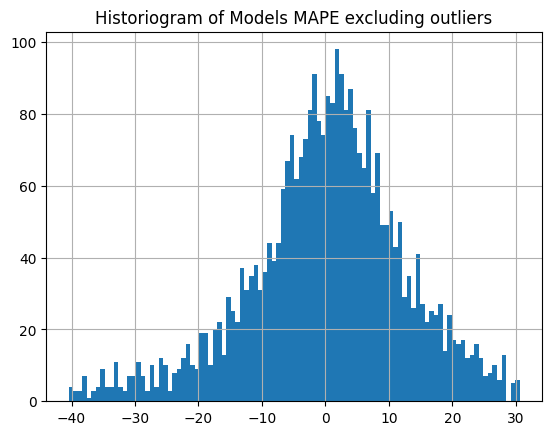

In [8]:
ax = exclude_top_and_bottom_x_percent(X_test_eval['perc_error'], 3).hist(bins=100)
ax.set_title('Historiogram of Models MAPE excluding outliers')

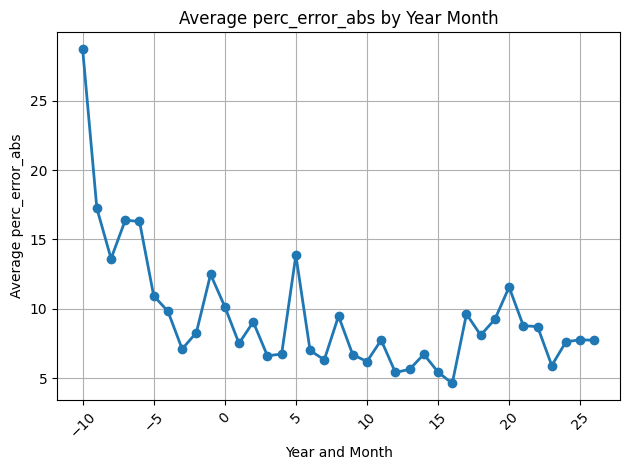

In [9]:
X_test_eval.groupby('relative_month_number').mean()['perc_error_abs'].plot(kind='line', marker='o', linestyle='-', linewidth=2, markersize=6)


plt.title('Average perc_error_abs by Year Month')  # Title of the plot
plt.xlabel('Year and Month')  # X-axis label
plt.ylabel('Average perc_error_abs')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

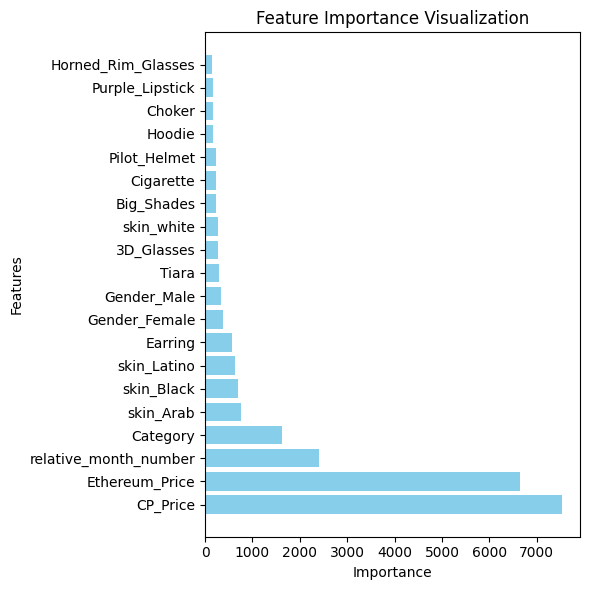

In [10]:
# Get feature importance
importance = bst.feature_importance()

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df =feature_importance_df[:20]
# Creating the plot
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.tight_layout()

# Show the plot
plt.show()

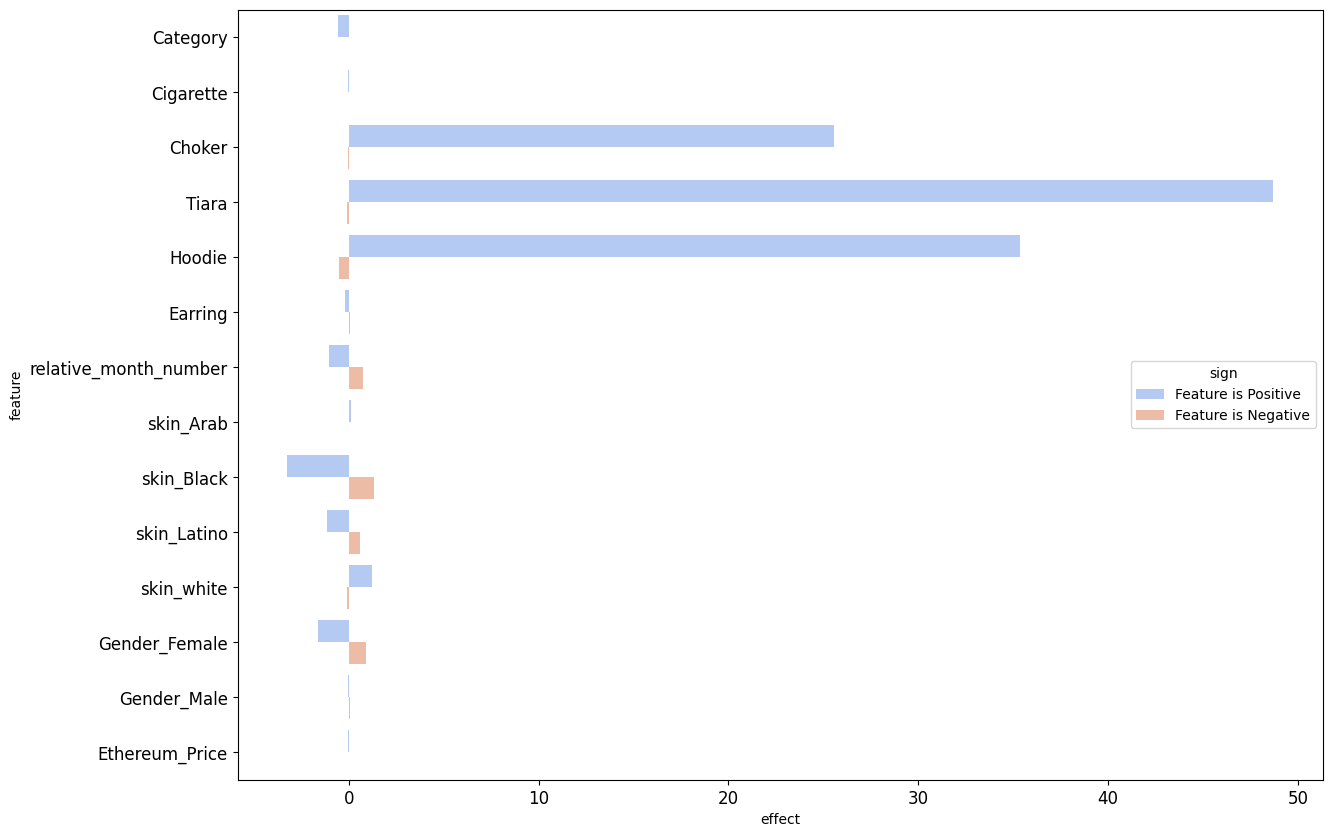

In [11]:
# Explainable AI
chosen_model = bst  

# Explain the model with SHAP
explainer = shap.TreeExplainer(chosen_model)
shap_values = explainer.shap_values(X_test)

shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

shap_df = shap_df[pd.Series(shap_df.columns)[pd.Series(shap_df.columns).isin(feature_importance_df['Feature Name'])]]

shap.initjs()


X_test_shap = X_test.copy()
X_test_shap.columns = X_test_shap.columns+"_value"
shap_df_feature_values = pd.concat([shap_df.reset_index(drop=True), X_test_shap.reset_index(drop=True)], axis=1)

# Append the SHAP values to the aggregate DataFrame
shap_aggregate = shap_df
all_y_test = y_test

shap_aggregate_feature_values = shap_df_feature_values
mean_shap_values = shap_aggregate.mean()

all_y_test.columns = ['y']

manual_effects = pd.DataFrame()

for i, column in enumerate(shap_df.columns):

   effects_feature = pd.concat([shap_aggregate_feature_values[[f'{column}', f'{column}_value']].reset_index(drop=True), all_y_test.reset_index(drop=True)], axis=1)
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Positive'
   m_effects.loc[0, 'effect'] = effects_feature[effects_feature[f'{column}_value'] >=1][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)
   
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Negative'
   m_effects.loc[0, 'effect'] =effects_feature[effects_feature[f'{column}_value'] ==0][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)

plt.figure(figsize=(14, 10))

sns.barplot(x='effect', y='feature', hue='sign', data=manual_effects, palette='coolwarm')
plt.tick_params(axis='y', labelsize=12)

plt.tick_params(labelsize=12)